In [1]:
# Check the schema and data types
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import NaiveBayes, LinearSVC, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.sql.types import IntegerType, DoubleType

In [2]:

# Initialize Spark session
spark = SparkSession.builder.appName('WaterPotability.1').getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/24 02:14:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/05/24 02:14:45 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [12]:
# Load the dataset
df = spark.read.csv("water_potability.1.csv", inferSchema=True)


In [13]:
# Show the first few rows of the dataset
df.show()

+-----+--------+--------+-----------+-------+------------+--------------+---------------+---------+----------+
|  _c0|     _c1|     _c2|        _c3|    _c4|         _c5|           _c6|            _c7|      _c8|       _c9|
+-----+--------+--------+-----------+-------+------------+--------------+---------------+---------+----------+
|   ph|Hardness|  Solids|Chloramines|Sulfate|Conductivity|Organic_carbon|Trihalomethanes|Turbidity|Potability|
| null|  204.89|20791.32|       7.30| 368.52|      564.31|         10.38|          86.99|     2.96|      0.00|
| 3.72|  129.42|18630.06|       6.64|   null|      592.89|         15.18|          56.33|     4.50|      0.00|
| 8.10|  224.24|19909.54|       9.28|   null|      418.61|         16.87|          66.42|     3.06|      0.00|
| 8.32|  214.37|22018.42|       8.06| 356.89|      363.27|         18.44|         100.34|     4.63|      0.00|
| 9.09|  181.10|17978.99|       6.55| 310.14|      398.41|         11.56|          32.00|     4.08|      0.00|
|

In [14]:

# Check the schema and data types
df.printSchema()


root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)
 |-- _c6: string (nullable = true)
 |-- _c7: string (nullable = true)
 |-- _c8: string (nullable = true)
 |-- _c9: string (nullable = true)



In [15]:
# Convert necessary columns to appropriate types if not already
df = df.withColumn("_c0", col("_c0").cast(DoubleType())) \
       .withColumn("_c1", col("_c1").cast(DoubleType())) \
       .withColumn("_c2", col("_c2").cast(DoubleType())) \
       .withColumn("_c3", col("_c3").cast(DoubleType())) \
       .withColumn("_c4", col("_c4").cast(DoubleType())) \
       .withColumn("_c5", col("_c5").cast(DoubleType())) \
       .withColumn("_c6", col("_c6").cast(DoubleType())) \
       .withColumn("_c7", col("_c7").cast(DoubleType())) \
       .withColumn("_c8", col("_c8").cast(DoubleType())) \
       .withColumn("_c9", col("_c9").cast(IntegerType()))

In [16]:
# Check for null values
df.select([col(c).isNull().sum().alias(c) for c in df.columns]).show()

TypeError: 'Column' object is not callable

In [17]:
# Drop rows with null values for simplicity
df = df.dropna()


In [18]:

# Describe the data
df.describe().show()

+-------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+-----------------+------------------+------------------+
|summary|               _c0|               _c1|              _c2|               _c3|              _c4|               _c5|               _c6|              _c7|               _c8|               _c9|
+-------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+-----------------+------------------+------------------+
|  count|              2011|              2011|             2011|              2011|             2011|              2011|              2011|             2011|              2011|              2011|
|   mean| 7.085987231196917|195.96806168241199|21917.44136749442| 7.134323658626552|333.2246789207866|426.52641016971626|14.357713743315271|66.40084781388023| 3.969715391888609|0.4032819492789657|
| stddev|1.5733

In [19]:
# Calculate correlation matrix
correlation_matrix = df.select([col for col in df.columns if col != '_c9']).toPandas().corr()

In [20]:

# Visualize correlations using seaborn and matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

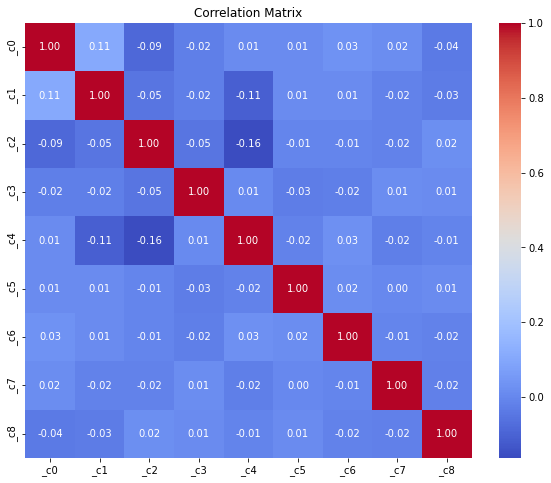

In [21]:

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()



In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Addtiional EDA and Visualization
# Use seaborn and matplotlib for visualization
sns.histplot(df.toPandas()['Chloramines'], kde=True)
plt.title('Distribution of Chloramines')
plt.show()



NameError: name 'df' is not defined

In [26]:

#Prepare for Machine Learning 

# Assemble features
feature_columns = [col for col in df.columns if col != '_c9']
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
df = assembler.transform(df)

In [24]:
# Select features and target variable
data = df.select('features', '_c9')


AnalysisException: cannot resolve 'features' given input columns: [_c0, _c1, _c2, _c3, _c4, _c5, _c6, _c7, _c8, _c9];
'Project ['features, _c9#1335]
+- Filter atleastnnonnulls(10, _c0#1236, _c1#1247, _c2#1258, _c3#1269, _c4#1280, _c5#1291, _c6#1302, _c7#1313, _c8#1324, _c9#1335)
   +- Project [_c0#1236, _c1#1247, _c2#1258, _c3#1269, _c4#1280, _c5#1291, _c6#1302, _c7#1313, _c8#1324, cast(_c9#1174 as int) AS _c9#1335]
      +- Project [_c0#1236, _c1#1247, _c2#1258, _c3#1269, _c4#1280, _c5#1291, _c6#1302, _c7#1313, cast(_c8#1173 as double) AS _c8#1324, _c9#1174]
         +- Project [_c0#1236, _c1#1247, _c2#1258, _c3#1269, _c4#1280, _c5#1291, _c6#1302, cast(_c7#1172 as double) AS _c7#1313, _c8#1173, _c9#1174]
            +- Project [_c0#1236, _c1#1247, _c2#1258, _c3#1269, _c4#1280, _c5#1291, cast(_c6#1171 as double) AS _c6#1302, _c7#1172, _c8#1173, _c9#1174]
               +- Project [_c0#1236, _c1#1247, _c2#1258, _c3#1269, _c4#1280, cast(_c5#1170 as double) AS _c5#1291, _c6#1171, _c7#1172, _c8#1173, _c9#1174]
                  +- Project [_c0#1236, _c1#1247, _c2#1258, _c3#1269, cast(_c4#1169 as double) AS _c4#1280, _c5#1170, _c6#1171, _c7#1172, _c8#1173, _c9#1174]
                     +- Project [_c0#1236, _c1#1247, _c2#1258, cast(_c3#1168 as double) AS _c3#1269, _c4#1169, _c5#1170, _c6#1171, _c7#1172, _c8#1173, _c9#1174]
                        +- Project [_c0#1236, _c1#1247, cast(_c2#1167 as double) AS _c2#1258, _c3#1168, _c4#1169, _c5#1170, _c6#1171, _c7#1172, _c8#1173, _c9#1174]
                           +- Project [_c0#1236, cast(_c1#1166 as double) AS _c1#1247, _c2#1167, _c3#1168, _c4#1169, _c5#1170, _c6#1171, _c7#1172, _c8#1173, _c9#1174]
                              +- Project [cast(_c0#1165 as double) AS _c0#1236, _c1#1166, _c2#1167, _c3#1168, _c4#1169, _c5#1170, _c6#1171, _c7#1172, _c8#1173, _c9#1174]
                                 +- Relation [_c0#1165,_c1#1166,_c2#1167,_c3#1168,_c4#1169,_c5#1170,_c6#1171,_c7#1172,_c8#1173,_c9#1174] csv


In [25]:
 #Split the data into training and testing sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

NameError: name 'data' is not defined

In [ ]:
#Model training with Naive Bayes
# Initialize Naive Bayes model
nb = NaiveBayes(featuresCol='features', labelCol='_c9')

In [ ]:
# Train the model
nb_model = nb.fit(train_data)


In [ ]:
# Make predictions
nb_predictions = nb_model.transform(test_data)


In [ ]:
# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="_c9", predictionCol="prediction", metricName="accuracy")
nb_accuracy = evaluator.evaluate(nb_predictions)
print(f'Naive Bayes Model Accuracy: {nb_accuracy}')


In [ ]:


#Model training with SVM
 # Initialize SVM model
svm = LinearSVC(featuresCol='features', labelCol='_c9')

In [ ]:
# Train the model
svm_model = svm.fit(train_data)

# Make predictions
svm_predictions = svm_model.transform(test_data)


In [ ]:
# Evaluate the model
svm_accuracy = evaluator.evaluate(svm_predictions)
print(f'SVM Model Accuracy: {svm_accuracy}')



In [ ]:
# Must be included at the beginning of each new notebook. Remember to change the app name.
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('tree_methods_doc').getOrCreate()

from pyspark.ml import Pipeline
from pyspark.ml.classification import (RandomForestClassifier, GBTClassifier, DecisionTreeClassifier)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [ ]:
# Load and parse the data file, converting it to a DataFrame.
data = spark.read.csv("water_potability.1.csv")

In [ ]:
# Let's get a better look at the data.
data.show()

data.printSchema()

In [ ]:
# Split the data into training and test sets (30% held out for testing).
(trainingData, testData) = data.randomSplit([0.7, 0.3])

In [ ]:
# Create all three models. Note the number of trees. 
# The more trees you have, the more computation time. But this could also significantly increase accuracy. So there's a tradeoff. 
dt = DecisionTreeClassifier()



In [ ]:
model_dt = dt.fit(trainingData)

In [ ]:

#SPARK DATA FRAME - DATA CLEANING
1-#CHANGING THE DATA TO NULL
2=#DROP THE DATA POINT
3-#FILL IN WITH A DIFF VALUE



#Must be included at the beginning of each new notebook. Remember to change the app name.
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('missing').getOrCreate()

In [ ]:
df = spark.read.csv("water_potability.1.csv", header=True, inferSchema=True)

In [ ]:
# Let's see the data. You'll notice nulls.
df.show()

In [ ]:
# Using this syntax, we can drop any row with missing data. Three rows are dropped.
df.na.drop().show()

In [ ]:
 #Requires a certain amount of non-null values. Row two was dropped, as there's only one non-null value.
df.na.drop(thresh=2).show()

In [ ]:
# Drops a row if all values are missing. Zero rows are dropped. 
df.na.drop(how="all").show()

In [ ]:
# Drops a row if a value from a particular row is missing. Two rows are dropped.
df.na.drop(subset="ph").show()

In [ ]:
# Drops a row if a value from a particular row is missing. Two rows are dropped.
df.na.drop(subset="Sulfate").show()

In [ ]:
# Instead of dropping the row, this fills null string types with FILL VALUE. 
df.na.fill("FILL VALUE").show()

# Spark will only apply numbers to number data types, and strings to string data types.
df.na.fill(0).show()





In [ ]:
# However, it's good practice to specify the row you want to fill using subset. 
df.na.fill('FILL NAME', subset=['ph','Sulfate']).show()

In [ ]:
# Also, it's good practice to use your sales average to fill missing data. 
from pyspark.sql.functions import mean

# Let's collect the average. You'll notice that the collection returns the average in an interesting format.
mean_ph = df.select(mean(df['ph'])).collect()
mean_ph

In [ ]:
# If we use the index, we should be able to access the actual value.
mean_ph[0]

In [ ]:
# Looks like we need to go one level deeper. Perfect! Let's assign that value to a variable.
mean_ph[0][0]
mean_ph_val = mean_ph[0][0]


In [ ]:
# And finally, fill the missing values with the mean.
df.na.fill(mean_ph_val, subset=['ph']).show()

In [ ]:
 #Must be included at the beginning of each new notebook. Remember to change the app name.
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('operations').getOrCreate()

In [ ]:
# Schemas can only be inferred for CSV files. 
df = spark.read.csv('water_potability.1.csv', inferSchema=True, header=True)
df.printSchema()

In [ ]:
# Let's get a better look at the data.
# We know that we can show a DataFrame, but that's resulted in a mess! 
df.show()

In [ ]:
# Instead, let's just grab the first row. Much neater! 
df.head(1)

In [27]:
#DATA FRAME METHODS
# Even though we know SQL is available, let's try out some of the DataFrame methods.
# For this example, let's have a look at the hardness and sulfate values where sulfate value is less that 400
df.filter("Sulfate < 400").select('Hardness','Sulfate').show()


AnalysisException: cannot resolve 'Sulfate' given input columns: [_c0, _c1, _c2, _c3, _c4, _c5, _c6, _c7, _c8, _c9, features]; line 1 pos 0;
'Filter ('Sulfate < 400)
+- Project [_c0#1236, _c1#1247, _c2#1258, _c3#1269, _c4#1280, _c5#1291, _c6#1302, _c7#1313, _c8#1324, _c9#1335, UDF(struct(_c0, _c0#1236, _c1, _c1#1247, _c2, _c2#1258, _c3, _c3#1269, _c4, _c4#1280, _c5, _c5#1291, _c6, _c6#1302, _c7, _c7#1313, _c8, _c8#1324)) AS features#2309]
   +- Filter atleastnnonnulls(10, _c0#1236, _c1#1247, _c2#1258, _c3#1269, _c4#1280, _c5#1291, _c6#1302, _c7#1313, _c8#1324, _c9#1335)
      +- Project [_c0#1236, _c1#1247, _c2#1258, _c3#1269, _c4#1280, _c5#1291, _c6#1302, _c7#1313, _c8#1324, cast(_c9#1174 as int) AS _c9#1335]
         +- Project [_c0#1236, _c1#1247, _c2#1258, _c3#1269, _c4#1280, _c5#1291, _c6#1302, _c7#1313, cast(_c8#1173 as double) AS _c8#1324, _c9#1174]
            +- Project [_c0#1236, _c1#1247, _c2#1258, _c3#1269, _c4#1280, _c5#1291, _c6#1302, cast(_c7#1172 as double) AS _c7#1313, _c8#1173, _c9#1174]
               +- Project [_c0#1236, _c1#1247, _c2#1258, _c3#1269, _c4#1280, _c5#1291, cast(_c6#1171 as double) AS _c6#1302, _c7#1172, _c8#1173, _c9#1174]
                  +- Project [_c0#1236, _c1#1247, _c2#1258, _c3#1269, _c4#1280, cast(_c5#1170 as double) AS _c5#1291, _c6#1171, _c7#1172, _c8#1173, _c9#1174]
                     +- Project [_c0#1236, _c1#1247, _c2#1258, _c3#1269, cast(_c4#1169 as double) AS _c4#1280, _c5#1170, _c6#1171, _c7#1172, _c8#1173, _c9#1174]
                        +- Project [_c0#1236, _c1#1247, _c2#1258, cast(_c3#1168 as double) AS _c3#1269, _c4#1169, _c5#1170, _c6#1171, _c7#1172, _c8#1173, _c9#1174]
                           +- Project [_c0#1236, _c1#1247, cast(_c2#1167 as double) AS _c2#1258, _c3#1168, _c4#1169, _c5#1170, _c6#1171, _c7#1172, _c8#1173, _c9#1174]
                              +- Project [_c0#1236, cast(_c1#1166 as double) AS _c1#1247, _c2#1167, _c3#1168, _c4#1169, _c5#1170, _c6#1171, _c7#1172, _c8#1173, _c9#1174]
                                 +- Project [cast(_c0#1165 as double) AS _c0#1236, _c1#1166, _c2#1167, _c3#1168, _c4#1169, _c5#1170, _c6#1171, _c7#1172, _c8#1173, _c9#1174]
                                    +- Relation [_c0#1165,_c1#1166,_c2#1167,_c3#1168,_c4#1169,_c5#1170,_c6#1171,_c7#1172,_c8#1173,_c9#1174] csv


In [ ]:
# We can also use Python within the DataFrame filter method!
df.filter(df['Sulfate'] < 400).select('Hardness','Sulfate').show()

In [ ]:
 #And we can use multiple operations! 
# Here we're looking for significant increases in stock.
df.filter( (df['Sulfate'] > 400) & (df['Hardness'] < 395) ).select('Hardness','Sulfate').show()

In [ ]:
#SPARK DATA FRAME AGGREGATION



In [ ]:
# Must be included at the beginning of each new notebook. Remember to change the app name.
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('aggregation').getOrCreate()

In [28]:
# Reads schema and accepts that the data has a header.
df = spark.read.csv('water_potability.1.csv', inferSchema=True, header=True)

# Let's see the data.
df.show()

# And the data schema.
df.printSchema()

+-----+--------+--------+-----------+-------+------------+--------------+---------------+---------+----------+
|   ph|Hardness|  Solids|Chloramines|Sulfate|Conductivity|Organic_carbon|Trihalomethanes|Turbidity|Potability|
+-----+--------+--------+-----------+-------+------------+--------------+---------------+---------+----------+
| null|  204.89|20791.32|        7.3| 368.52|      564.31|         10.38|          86.99|     2.96|       0.0|
| 3.72|  129.42|18630.06|       6.64|   null|      592.89|         15.18|          56.33|      4.5|       0.0|
|  8.1|  224.24|19909.54|       9.28|   null|      418.61|         16.87|          66.42|     3.06|       0.0|
| 8.32|  214.37|22018.42|       8.06| 356.89|      363.27|         18.44|         100.34|     4.63|       0.0|
| 9.09|   181.1|17978.99|       6.55| 310.14|      398.41|         11.56|           32.0|     4.08|       0.0|
| 5.58|  188.31|28748.69|       7.54| 326.68|      280.47|           8.4|          54.92|     2.56|       0.0|
|

In [29]:
# We can also group, and show the averages of each group.
df.groupBy('Ph').mean().show()
df.groupBy('Sulfate').mean().show()
df.groupBy('Potability').mean().show()
#each of it can be done

+-----------+-----------+-------------+-----------+----------------+------------+-----------------+-------------------+--------------------+--------------+---------------+
|         Ph|    avg(ph)|avg(Hardness)|avg(Solids)|avg(Chloramines)|avg(Sulfate)|avg(Conductivity)|avg(Organic_carbon)|avg(Trihalomethanes)|avg(Turbidity)|avg(Potability)|
+-----------+-----------+-------------+-----------+----------------+------------+-----------------+-------------------+--------------------+--------------+---------------+
|7.466213132|7.466213132|  223.1841808|18261.69494|     5.206596781|        null|      456.2621506|        14.02354722|         99.13033596|   2.081845657|            0.0|
|5.527633483|5.527633483|  218.5189231|22095.63716|     6.436288161|        null|      412.8676105|        12.64013548|         44.32864139|    4.59113705|            0.0|
|6.871607245|6.871607245|  197.5170934|19557.99372|     8.311348727| 355.0872579|      379.5077385|        18.24071162|         65.69423039|

+----------+-----------------+------------------+------------------+-----------------+-----------------+------------------+-------------------+--------------------+-----------------+---------------+
|Potability|          avg(ph)|     avg(Hardness)|       avg(Solids)| avg(Chloramines)|     avg(Sulfate)| avg(Conductivity)|avg(Organic_carbon)|avg(Trihalomethanes)|   avg(Turbidity)|avg(Potability)|
+----------+-----------------+------------------+------------------+-----------------+-----------------+------------------+-------------------+--------------------+-----------------+---------------+
|       0.0|7.085377288204867|196.73328431532053|21777.490781777895|7.092156204221223|334.5642993056295|426.73046905325344| 14.364347931442447|   66.30354620526703|3.965802536707207|            0.0|
|       1.0|7.073783295348782|195.80074426245721|22383.991017830645| 7.16933802623318|332.5669902327923|425.38379997840417|   14.1608925211244|   66.53968374061084|3.968328289134596|            1.0|
+----

In [30]:
# Instead of grouping, you can use aggregation which represents the entire dataset. 
df.agg({"Potability":"mean"}).show()
df.agg({"Sulfate":"mean"}).show()
df.agg({"Hardness":"mean"}).show()
df.agg({"ph":"mean"}).show()

+------------------+
|   avg(Potability)|
+------------------+
|0.3901098901098901|
+------------------+

+------------------+
|      avg(Sulfate)|
+------------------+
|333.77578249731533|
+------------------+

+------------------+
|     avg(Hardness)|
+------------------+
|196.36949121777474|
+------------------+

+----------------+
|         avg(ph)|
+----------------+
|7.08079381023912|
+----------------+



In [31]:
# We can also import SQL functions. 
from pyspark.sql.functions import countDistinct,avg,stddev,format_number
df.select(avg('Sulfate').alias('Average Sulfate')).show()
#can do of others

+------------------+
|   Average Sulfate|
+------------------+
|333.77578249731533|
+------------------+



In [32]:
# We can use SQL to do some basic manipulation.
# Here we're getting the standard deviation in sulfate, formatting it to two decimal places and changing the column name.
dev = df.select(stddev("Sulfate"))

dev.select(format_number('stddev_samp(Sulfate)',2).alias('Sulfate_Standard_Deviation')).show()
#of others

dev = df.select(stddev("ph"))

dev.select(format_number('stddev_samp(ph)',2).alias('ph_Standard_Deviation')).show()

+--------------------------+
|Sulfate_Standard_Deviation|
+--------------------------+
|                     41.42|
+--------------------------+

+---------------------+
|ph_Standard_Deviation|
+---------------------+
|                 1.59|
+---------------------+



In [33]:
# Here's also a simple example of an ascending and descending sort by sulfate
df.orderBy('Sulfate').show()

df.orderBy(df['Sulfate'].desc()).show()

+-----------+-----------+-----------+-----------+-------+------------+--------------+---------------+-----------+----------+
|         ph|   Hardness|     Solids|Chloramines|Sulfate|Conductivity|Organic_carbon|Trihalomethanes|  Turbidity|Potability|
+-----------+-----------+-----------+-----------+-------+------------+--------------+---------------+-----------+----------+
|       4.76|     183.35|   21568.43|       4.73|   null|      403.94|         18.67|          66.91|       4.54|       0.0|
|1.844538366|233.7643427|28689.59578|  7.7244323|   null| 410.3872638|    15.6118593|    54.29944409|5.013463351|       0.0|
|        5.7|     216.85|   35606.44|       7.18|   null|      504.64|         16.14|          77.54|       4.14|       0.0|
|        8.1|     224.24|   19909.54|       9.28|   null|      418.61|         16.87|          66.42|       3.06|       0.0|
|       null|     227.44|   22305.57|      10.33|   null|      554.82|         16.33|          45.38|       4.13|       0.0|


In [34]:
# Must be included at the beginning of each new notebook. Remember to change the app name.
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('tree_methods_adv').getOrCreate()

In [35]:
# Load training data. 
data = spark.read.csv('water_potability.1.csv',inferSchema=True,header=True)

In [36]:
# Let's get an idea of what the data looks like. 
data.printSchema()

root
 |-- ph: double (nullable = true)
 |-- Hardness: double (nullable = true)
 |-- Solids: double (nullable = true)
 |-- Chloramines: double (nullable = true)
 |-- Sulfate: double (nullable = true)
 |-- Conductivity: double (nullable = true)
 |-- Organic_carbon: double (nullable = true)
 |-- Trihalomethanes: double (nullable = true)
 |-- Turbidity: double (nullable = true)
 |-- Potability: double (nullable = true)



In [37]:
data.head()

Row(ph=None, Hardness=204.89, Solids=20791.32, Chloramines=7.3, Sulfate=368.52, Conductivity=564.31, Organic_carbon=10.38, Trihalomethanes=86.99, Turbidity=2.96, Potability=0.0)

In [38]:
# A few things we need to do before Spark can accept the data!
# It needs to be in the form of two columns: "name" and "numbers".

# Import VectorAssembler and Vectors
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [39]:
# Let's visualise the columns to help with assembly. 
data.columns

['ph',
 'Hardness',
 'Solids',
 'Chloramines',
 'Sulfate',
 'Conductivity',
 'Organic_carbon',
 'Trihalomethanes',
 'Turbidity',
 'Potability']

In [40]:
# Must be included at the beginning of each new notebook. Remember to change the app name.
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import *
spark = SparkSession.builder.appName('logistic_regression_adv').getOrCreate()

# If you're getting an error with numpy, please type 'sudo pip install numpy --user' into the EC2 console.
from pyspark.ml.classification import LogisticRegression

In [41]:
 # Read in the CSV data.
data = spark.read.csv("water_potability.1.csv")

In [42]:

# Print data schema.
data.printSchema()

# Print data columns.
data.columns


root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)
 |-- _c6: string (nullable = true)
 |-- _c7: string (nullable = true)
 |-- _c8: string (nullable = true)
 |-- _c9: string (nullable = true)



['_c0', '_c1', '_c2', '_c3', '_c4', '_c5', '_c6', '_c7', '_c8', '_c9']

In [43]:

from pyspark.ml.feature import (VectorAssembler,VectorIndexer,
                                OneHotEncoder,StringIndexer)


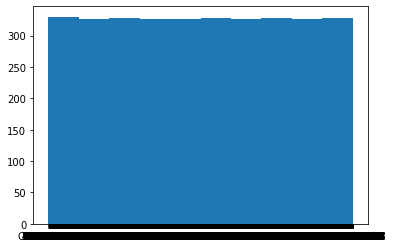

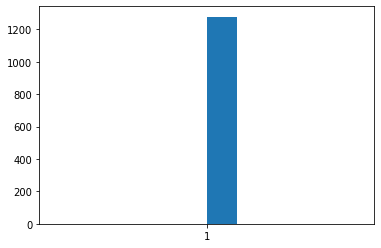

In [44]:
# Import the relevant Python libraries.
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Convert Sulfate to an array using Numpy and plot it using pyplot. 
_c3Arr = np.array(data.select('_c3').collect())
plt.hist(_c3Arr)
plt.show()

# Because you can interact with Spark using SQL, you can also filter the data you see. 
# For example, age has some null values. We can remove all null values before visualising the data.
_c9Arr = np.array(data.filter('_c9> 0').select('_c9').collect())
plt.hist(_c9Arr)
plt.show()

In [ ]:
# Import the relevant Python libraries.
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Convert Sulfate to an array using Numpy and plot it using pyplot. 
_c3Arr = np.array(data.select('_c3').collect())
plt.hist(_c3Arr)
plt.show()

# Because you can interact with Spark using SQL, you can also filter the data you see. 
# For example, age has some null values. We can remove all null values before visualising the data.
_c8Arr = np.array(data.filter('_c8> 0').select('_c8').collect())
plt.hist(_c8Arr)
plt.show()

In [57]:
# Must be included at the beginning of each new notebook. Remember to change the app name.
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('linear_regression_adv').getOrCreate()

# If you're getting an error with numpy, please type 'sudo pip install numpy --user' into the EC2 console.
from pyspark.ml.regression import LinearRegression

In [58]:
data = spark.read.csv("water_potability.1.csv",inferSchema=True,header=True)

In [59]:
# Print the schema of the DataFrame. You can see potential features as well as the predictor.
data.printSchema()

root
 |-- ph: double (nullable = true)
 |-- Hardness: double (nullable = true)
 |-- Solids: double (nullable = true)
 |-- Chloramines: double (nullable = true)
 |-- Sulfate: double (nullable = true)
 |-- Conductivity: double (nullable = true)
 |-- Organic_carbon: double (nullable = true)
 |-- Trihalomethanes: double (nullable = true)
 |-- Turbidity: double (nullable = true)
 |-- Potability: double (nullable = true)



In [60]:
# Let's focus on one row to make it easier to read.
data.head()

Row(ph=None, Hardness=204.89, Solids=20791.32, Chloramines=7.3, Sulfate=368.52, Conductivity=564.31, Organic_carbon=10.38, Trihalomethanes=86.99, Turbidity=2.96, Potability=0.0)

In [61]:
# A simple for loop allows us to make it even clearer. 
for item in data.head():
    print(item)

None
204.89
20791.32
7.3
368.52
564.31
10.38
86.99
2.96
0.0


In [62]:
#Setting Up a DataFrame for Machine Learning (MLlib)


# Import VectorAssembler and Vectors
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [63]:
#The input columns are the feature column names, and the output column is what you'd like the new column to be named. 
assembler = VectorAssembler(
    inputCols=["ph", "Hardness", "Solids",],
    outputCol="features")


In [64]:
# Now that we've created the assembler variable, let's actually transform the data.
output = assembler.transform(data)

In [65]:
# Using print schema, you see that the features output column has been added. 
output.printSchema()

# You can see that the features column is a dense vector that combines the various features as expected.
output.head(1)


root
 |-- ph: double (nullable = true)
 |-- Hardness: double (nullable = true)
 |-- Solids: double (nullable = true)
 |-- Chloramines: double (nullable = true)
 |-- Sulfate: double (nullable = true)
 |-- Conductivity: double (nullable = true)
 |-- Organic_carbon: double (nullable = true)
 |-- Trihalomethanes: double (nullable = true)
 |-- Turbidity: double (nullable = true)
 |-- Potability: double (nullable = true)
 |-- features: vector (nullable = true)



24/05/24 02:20:38 ERROR Executor: Exception in task 0.0 in stage 70.0 (TID 58)
org.apache.spark.SparkException: Failed to execute user defined function (VectorAssembler$$Lambda$3415/0x000000084135e840: (struct<ph:double,Hardness:double,Solids:double>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>)
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:136)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:759)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:349)
	at org.apache.sp

Py4JJavaError: An error occurred while calling o451.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 70.0 failed 1 times, most recent failure: Lost task 0.0 in stage 70.0 (TID 58) (ip-172-31-55-62.ec2.internal executor driver): org.apache.spark.SparkException: Failed to execute user defined function (VectorAssembler$$Lambda$3415/0x000000084135e840: (struct<ph:double,Hardness:double,Solids:double>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>)
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:136)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:759)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:349)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:898)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:898)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1462)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: org.apache.spark.SparkException: Encountered null while assembling a row with handleInvalid = "error". Consider
removing nulls from dataset or using handleInvalid = "keep" or "skip".
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1(VectorAssembler.scala:291)
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1$adapted(VectorAssembler.scala:260)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.WrappedArray.foreach(WrappedArray.scala:38)
	at org.apache.spark.ml.feature.VectorAssembler$.assemble(VectorAssembler.scala:260)
	at org.apache.spark.ml.feature.VectorAssembler.$anonfun$transform$6(VectorAssembler.scala:143)
	... 17 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2454)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2403)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2402)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2402)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1160)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1160)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1160)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2642)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2584)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2573)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:938)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2214)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2235)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2254)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:476)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:429)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:48)
	at org.apache.spark.sql.Dataset.$anonfun$collectToPython$1(Dataset.scala:3538)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3706)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:90)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:775)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3704)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3535)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: org.apache.spark.SparkException: Failed to execute user defined function (VectorAssembler$$Lambda$3415/0x000000084135e840: (struct<ph:double,Hardness:double,Solids:double>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>)
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:136)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:759)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:349)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:898)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:898)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1462)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more
Caused by: org.apache.spark.SparkException: Encountered null while assembling a row with handleInvalid = "error". Consider
removing nulls from dataset or using handleInvalid = "keep" or "skip".
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1(VectorAssembler.scala:291)
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1$adapted(VectorAssembler.scala:260)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.WrappedArray.foreach(WrappedArray.scala:38)
	at org.apache.spark.ml.feature.VectorAssembler$.assemble(VectorAssembler.scala:260)
	at org.apache.spark.ml.feature.VectorAssembler.$anonfun$transform$6(VectorAssembler.scala:143)
	... 17 more


In [66]:
# Let's do a randomised 70/30 split. 
# Remember, you can use other splits depending on how easy/difficult it is to train your model.
train_data,test_data = final_data.randomSplit([0.7,0.3])

NameError: name 'final_data' is not defined